# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import cv2
import pickle
import datetime
import time
import random
import collections

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import multiprocessing as mp 
from glob import glob
import timeit

# helper

In [ ]:
CHANNEL_NUM = 3

# this function gets the average mean of each channel of the given set of images
def cal_dir_stat(root):
    cls_dirs = [d for d in listdir(root) if isdir(join(root, d))]
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(CHANNEL_NUM)
    channel_sum_squared = np.zeros(CHANNEL_NUM)

    for idx, d in enumerate(cls_dirs):
        print("#{} class".format(idx))
        im_pths = glob(join(root, d, "*.jpg"))

        for path in im_pths:
            im = cv2.imread(path) # image in M*N*CHANNEL_NUM shape, channel in BGR order
            pixel_num += (im.size/CHANNEL_NUM)
            channel_sum += np.sum(im, axis=(0, 1))
            channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std
#rgb_mean = [149.695, 120.739, 89.515]
# The script assumes that under train_root, there are separate directories for each class
# of training images.
train_root = 'food-101/test'
cal_dir_stat(train_root)

# load and pre-process data by subtracting mean of entire training set from each pixel in the image

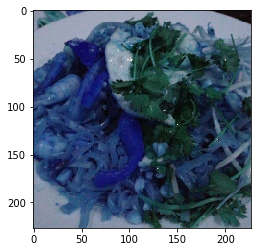

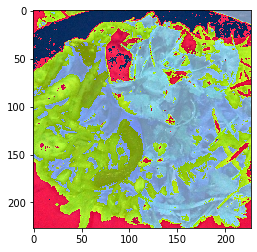

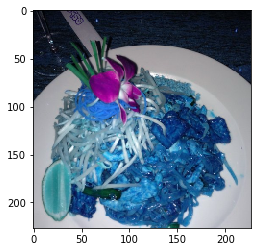

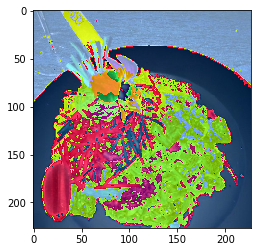

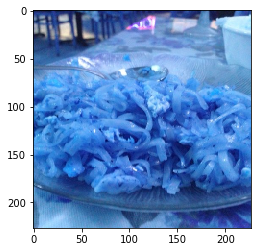

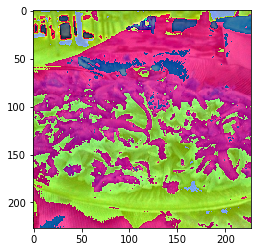

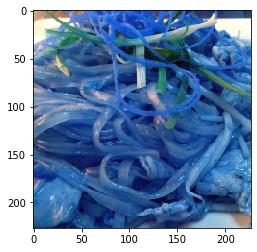

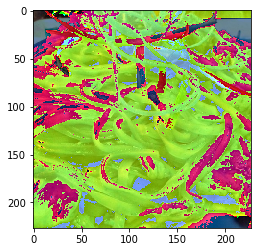

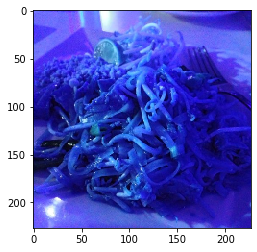

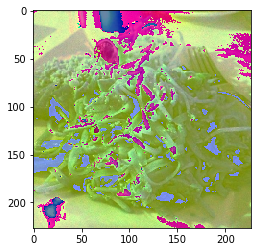

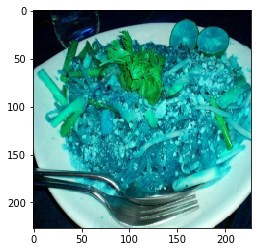

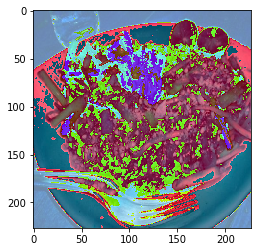

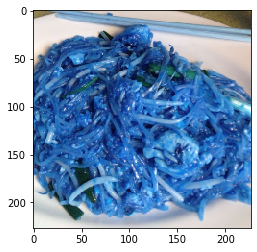

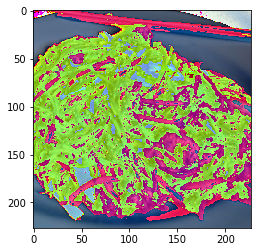

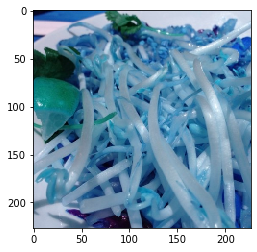

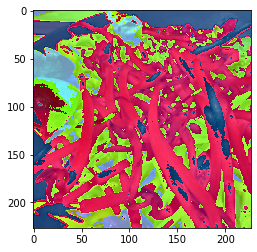

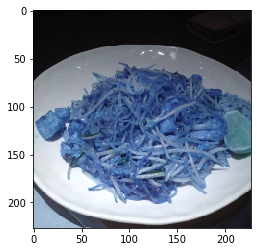

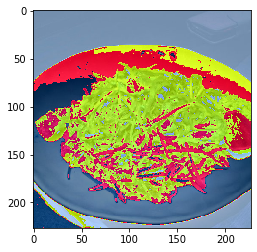

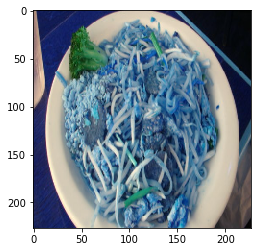

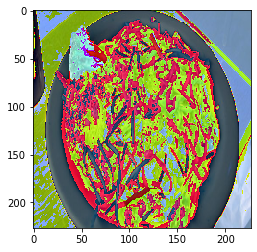

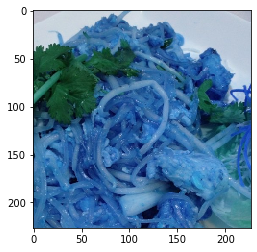

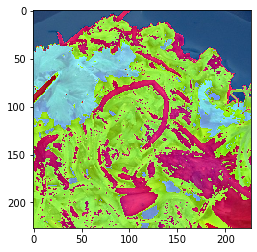

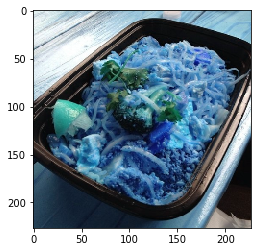

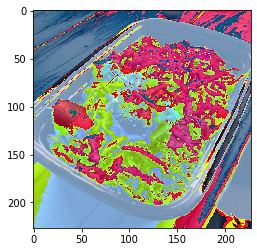

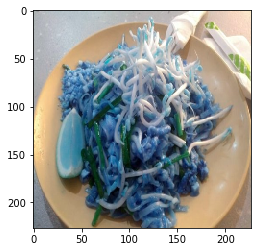

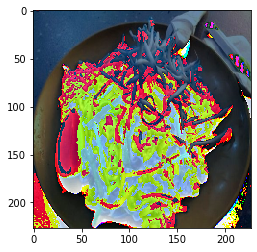

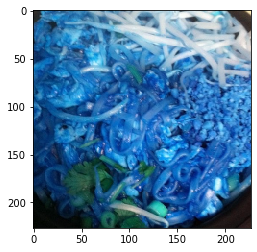

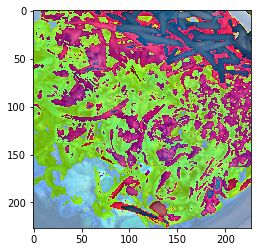

KeyboardInterrupt: 

In [137]:
NUM_CLASSES = 5
IMG_SIZE = 227
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                #img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                #new_img = new_img.astype('float32')
                plt.imshow(new_img)
                plt.show()
            
                # rgb_mean = [149.695, 120.739, 89.515] pre-computing mean of the entire training set
                # subtract mean from each image
                new_img[:,:,0] = np.subtract(new_img[:,:,0],149.695)
                new_img[:,:,1] = np.subtract(new_img[:,:,1],120.739)
                new_img[:,:,2] = np.subtract(new_img[:,:,2],89.515)

                plt.imshow(new_img)
                plt.show()
                #print(new_img)
                #per_channel_mean = np.mean(new_img, axis=(0))
                #new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)


        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y

at, at2 = create_data('food-101/test',"test")

# helper function to prepare test data

In [30]:
# this function prepares the test data but does not augment it
def prepare_test_data():
    data_set = []
    test_dir = '/Users/flo/Desktop/456/_SEMESTER_PROJECT/food-101/test' 
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(test_dir, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        print(noodle_class,label)
        #input('wait1')

        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
                if img.startswith('.'): # .DS_Store
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img))
                    img_to_rgb = img_arr[:,:,::-1] 
                    new_img = cv2.resize(img_to_rgb,(227,227)) 

                    features.append(new_img) # shove (X,y) in here cause we wanna shuffle 
                    labels.append(label)
                except Exception as e:
                    print("create exception: ",e)
        
    X = np.array(features).reshape(-1, 227, 227, 3) # -1 = any number of features (catch-all, it'll recognize)
    y = np.array(labels).reshape(-1, 1)

    return X,y

X_test, y_test = prepare_test_data()
X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, 5)

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4


# load and pre-process data by subtracting mean of each color from each channel vector per image

In [6]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                mean_activity = np.round(np.mean(img_arr, axis=(0,1)),0)
                
                ftr_wise_norm_img = np.subtract(mean_activity,img_arr)
                resized_img = cv2.resize(ftr_wise_norm_img, (227, 227))

                #plt.imshow(resized_img)
                #plt.show()

                features.append(resized_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y


# create data, normalize and convert y labels to one hot vectors

In [7]:
X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

# Iteration 11

In [9]:
# feature wise normalization
# lr scheduler
# batch_size = 32
# epochs 30

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 11
learn_rate = 0.001
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger(checkpoint_path+'.log')

# def schedule(epoch):
#     if epoch < 5:
#         return .01
#     elif epoch < 25:
#         return .001
#     else:
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/11.h5')

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  20:35:21
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.5003 - accuracy: 0.3454
Epoch 00001: val_loss improved from inf to 1.64560, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/11-32-bsz-0.001-lr-30-ep.01-1.65.hdf5
3750/3750 [==============================] - 131s 35ms/sample - loss: 1.5000 - accuracy: 0.3453 - val_loss: 1.6456 - val_accuracy: 0.2000
Epoch 2/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.3211 - accuracy: 0.4506
Epoch 00002: val_loss did not improve from 1.64560
3750/3750 [==============================] - 110s 29ms/sample - loss: 1.3217 - accuracy: 0.4501 - val_loss: 2.0102 - val_accuracy: 0.2000
Epoch 3/30
3744/3750 [=========================

Epoch 26/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.9105
Epoch 00026: val_loss did not improve from 0.86447
3750/3750 [==============================] - 109s 29ms/sample - loss: 0.2571 - accuracy: 0.9107 - val_loss: 1.0636 - val_accuracy: 0.6606
Epoch 27/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9319
Epoch 00027: val_loss did not improve from 0.86447
3750/3750 [==============================] - 116s 31ms/sample - loss: 0.2036 - accuracy: 0.9320 - val_loss: 1.1734 - val_accuracy: 0.6766
Epoch 28/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9287
Epoch 00028: val_loss did not improve from 0.86447
3750/3750 [==============================] - 113s 30ms/sample - loss: 0.1999 - accuracy: 0.9283 - val_loss: 1.0500 - val_accuracy: 0.6891
Epoch 29/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.9132
Epoch 00029: val_loss did not improve

In [20]:
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_16 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 256)       1024      
_________________________________________________________________
activation_17 (Activation)   (None, 25, 25, 256)      

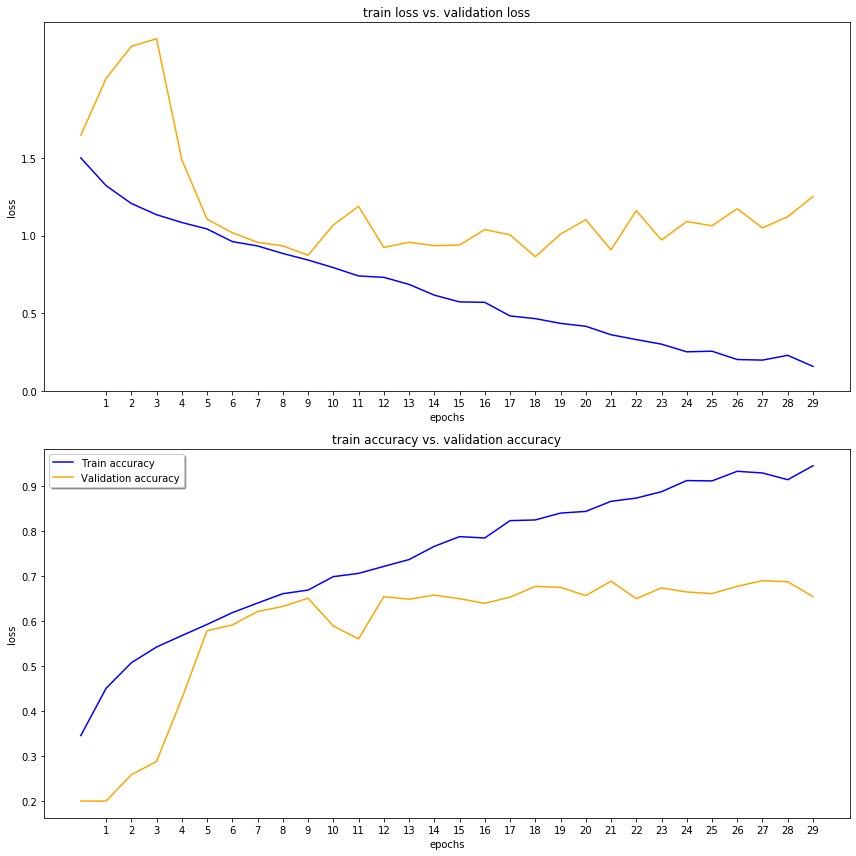

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 12

In [29]:
# feature wise normalization
# learn_rate 0.0001
# batch_size = 32
# epochs 30
# 1 drop out 1 normal

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 12
learn_rate = 0.0001
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger(checkpoint_path+'.log')

# def schedule(epoch):
#     if epoch < 5:
#         return .01
#     elif epoch < 25:
#         return .001
#     else:
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/12.h5')

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  22:37:54
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.6109 - accuracy: 0.2065
Epoch 00001: val_loss improved from inf to 1.60803, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/12-32-bsz-0.0001-lr-30-ep.01-1.61.hdf5
3750/3750 [==============================] - 110s 29ms/sample - loss: 1.6108 - accuracy: 0.2069 - val_loss: 1.6080 - val_accuracy: 0.3086
Epoch 2/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.5881 - accuracy: 0.2754
Epoch 00002: val_loss improved from 1.60803 to 1.60359, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/12-32-bsz-0.0001-lr-30-ep.02-1.60.hdf5
3750/3750 [==============================] - 112s 30ms/sample - loss: 1

In [31]:
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_30 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_31 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 256)      

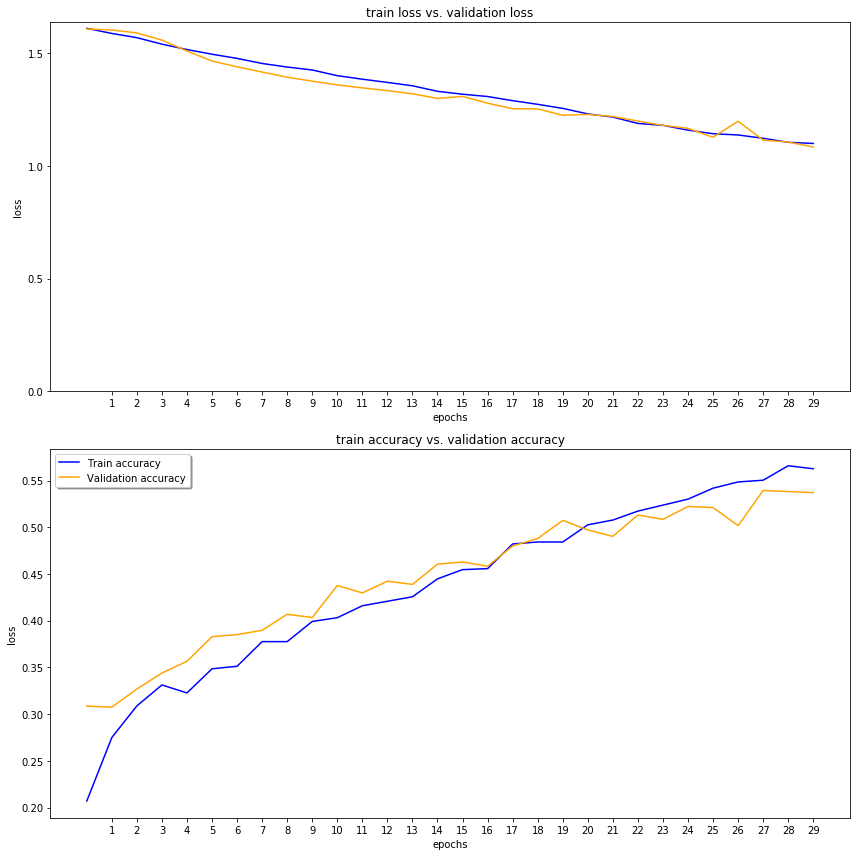

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 13

In [35]:
# feature wise normalization
# learn_rate 0.0001,00005,000001
# batch_size = 15
# epochs 50
# 1 drop out (0.4) 1 normal

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 13
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 20:
        return .0001
    elif epoch < 25:
        return .00005
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/13.h5')

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  00:50:40
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.5728 - accuracy: 0.2704
Epoch 00001: val_loss improved from inf to 1.58807, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/13-15-bsz-0.0001-lr-50-ep.01-1.59.hdf5
3750/3750 [==============================] - 134s 36ms/sample - loss: 1.5727 - accuracy: 0.2709 - val_loss: 1.5881 - val_accuracy: 0.3303
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.4879 - accuracy: 0.3475
Epoch 00002: val_loss improved from 1.58807 to 1.49280, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/13-15-bsz-0.0001-lr-50-ep.02-1.49.hdf5
3750/3750 [==============================] - 136s 36ms/sample - loss: 1

Epoch 23/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8423 - accuracy: 0.6851
Epoch 00023: val_loss did not improve from 0.90828
3750/3750 [==============================] - 135s 36ms/sample - loss: 0.8419 - accuracy: 0.6853 - val_loss: 1.0025 - val_accuracy: 0.6034
Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8072 - accuracy: 0.7025
Epoch 00024: val_loss did not improve from 0.90828
3750/3750 [==============================] - 136s 36ms/sample - loss: 0.8071 - accuracy: 0.7029 - val_loss: 0.9186 - val_accuracy: 0.6366
Epoch 25/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.6945
Epoch 00025: val_loss did not improve from 0.90828
3750/3750 [==============================] - 141s 38ms/sample - loss: 0.8093 - accuracy: 0.6939 - val_loss: 0.9359 - val_accuracy: 0.6331
Epoch 26/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.7718 - accuracy: 0.7143
Epoch 00026: val_loss did not improve

Epoch 50/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8667
Epoch 00050: val_loss did not improve from 0.79565
3750/3750 [==============================] - 121s 32ms/sample - loss: 0.4055 - accuracy: 0.8664 - val_loss: 0.8364 - val_accuracy: 0.6971
Training end  02:37:49


# Iteration 14

In [36]:
# lr schedule
# dense 2048,2048
# epochs 50
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 14
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 20:
        return .0001
    elif epoch < 25:
        return .00005
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  02:37:51
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.5849 - accuracy: 0.2602
Epoch 00001: val_loss improved from inf to 1.59308, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/14-15-bsz-0.0001-lr-50-ep.01-1.59.hdf5
3750/3750 [==============================] - 93s 25ms/sample - loss: 1.5846 - accuracy: 0.2608 - val_loss: 1.5931 - val_accuracy: 0.3360
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.5070 - accuracy: 0.3483
Epoch 00002: val_loss improved from 1.59308 to 1.51479, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/14-15-bsz-0.0001-lr-50-ep.02-1.51.hdf5
3750/3750 [==============================] - 84s 22ms/sample - loss: 1.5

Epoch 22/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8497 - accuracy: 0.6760
Epoch 00022: val_loss did not improve from 0.95013
3750/3750 [==============================] - 83s 22ms/sample - loss: 0.8488 - accuracy: 0.6768 - val_loss: 0.9688 - val_accuracy: 0.6091
Epoch 23/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8482 - accuracy: 0.6827
Epoch 00023: val_loss improved from 0.95013 to 0.93235, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/14-15-bsz-0.0001-lr-50-ep.23-0.93.hdf5
3750/3750 [==============================] - 84s 22ms/sample - loss: 0.8504 - accuracy: 0.6819 - val_loss: 0.9324 - val_accuracy: 0.6309
Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8195 - accuracy: 0.6918
Epoch 00024: val_loss improved from 0.93235 to 0.90695, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/14-15-bsz-0.0001-lr-50-ep.24-0.91.hdf5
3750/3750 [==============================] - 84s 2

Epoch 47/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8396
Epoch 00047: val_loss did not improve from 0.83127
3750/3750 [==============================] - 84s 22ms/sample - loss: 0.4620 - accuracy: 0.8395 - val_loss: 0.8476 - val_accuracy: 0.6857
Epoch 48/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.4540 - accuracy: 0.8463
Epoch 00048: val_loss did not improve from 0.83127
3750/3750 [==============================] - 84s 22ms/sample - loss: 0.4531 - accuracy: 0.8464 - val_loss: 0.9008 - val_accuracy: 0.6789
Epoch 49/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.4357 - accuracy: 0.8444
Epoch 00049: val_loss did not improve from 0.83127
3750/3750 [==============================] - 83s 22ms/sample - loss: 0.4361 - accuracy: 0.8440 - val_loss: 0.8471 - val_accuracy: 0.6834
Epoch 50/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.4138 - accuracy: 0.8578
Epoch 00050: val_loss did not improve fr

In [37]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/14.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_12 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_57 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_58 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 256)      

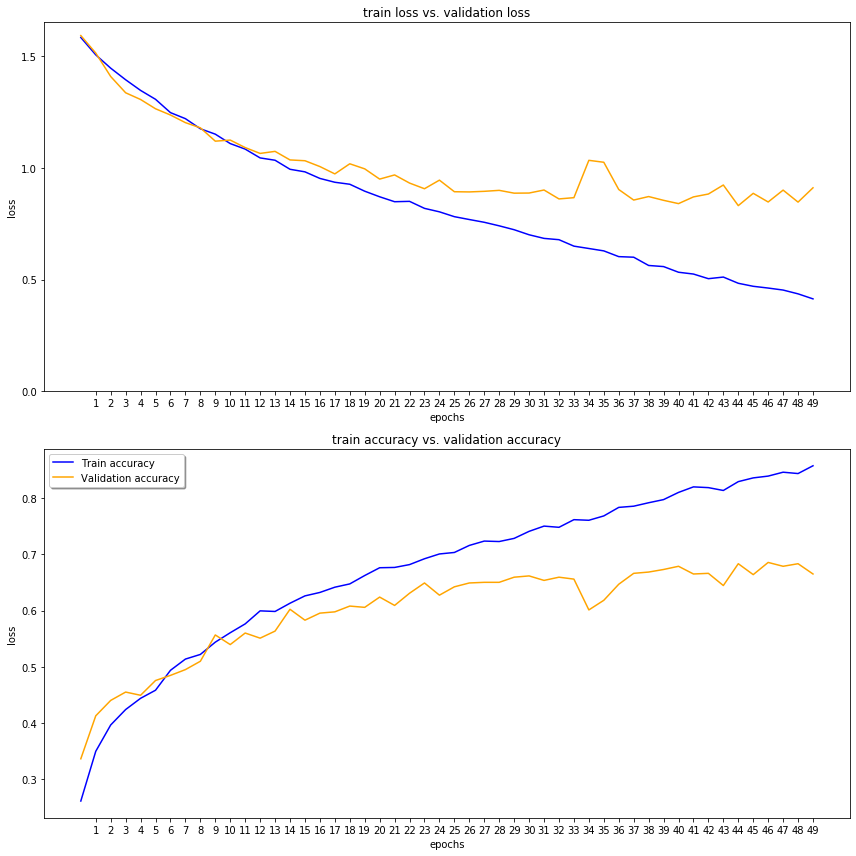

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 15

In [39]:
# lr schedule
# dense 2048,2048
# epochs 50
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 15
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 20:
        return .0001
    elif epoch < 25:
        return .00005
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  03:48:31
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.4944 - accuracy: 0.3606
Epoch 00001: val_loss improved from inf to 1.65553, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/15-15-bsz-0.0001-lr-50-ep.01-1.66.hdf5
3750/3750 [==============================] - 91s 24ms/sample - loss: 1.4948 - accuracy: 0.3611 - val_loss: 1.6555 - val_accuracy: 0.2000
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.2731 - accuracy: 0.4822
Epoch 00002: val_loss did not improve from 1.65553
3750/3750 [==============================] - 89s 24ms/sample - loss: 1.2730 - accuracy: 0.4827 - val_loss: 1.7525 - val_accuracy: 0.2937
Epoch 3/50
3735/3750 [==========================

Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.9074
Epoch 00024: val_loss did not improve from 0.88699
3750/3750 [==============================] - 88s 24ms/sample - loss: 0.3026 - accuracy: 0.9075 - val_loss: 0.8960 - val_accuracy: 0.6766
Epoch 25/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.2589 - accuracy: 0.9250
Epoch 00025: val_loss did not improve from 0.88699
3750/3750 [==============================] - 88s 24ms/sample - loss: 0.2586 - accuracy: 0.9253 - val_loss: 0.8871 - val_accuracy: 0.6903
Epoch 26/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9282
Epoch 00026: val_loss did not improve from 0.88699
3750/3750 [==============================] - 89s 24ms/sample - loss: 0.2447 - accuracy: 0.9275 - val_loss: 0.9686 - val_accuracy: 0.6571
Epoch 27/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9456
Epoch 00027: val_loss did not improve fr

In [40]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/15.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_13 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_63 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
batch_normalization_14 (Batc (None, 25, 25, 256)       1024      
_________________________________________________________________
activation_64 (Activation)   (None, 25, 25, 256)      

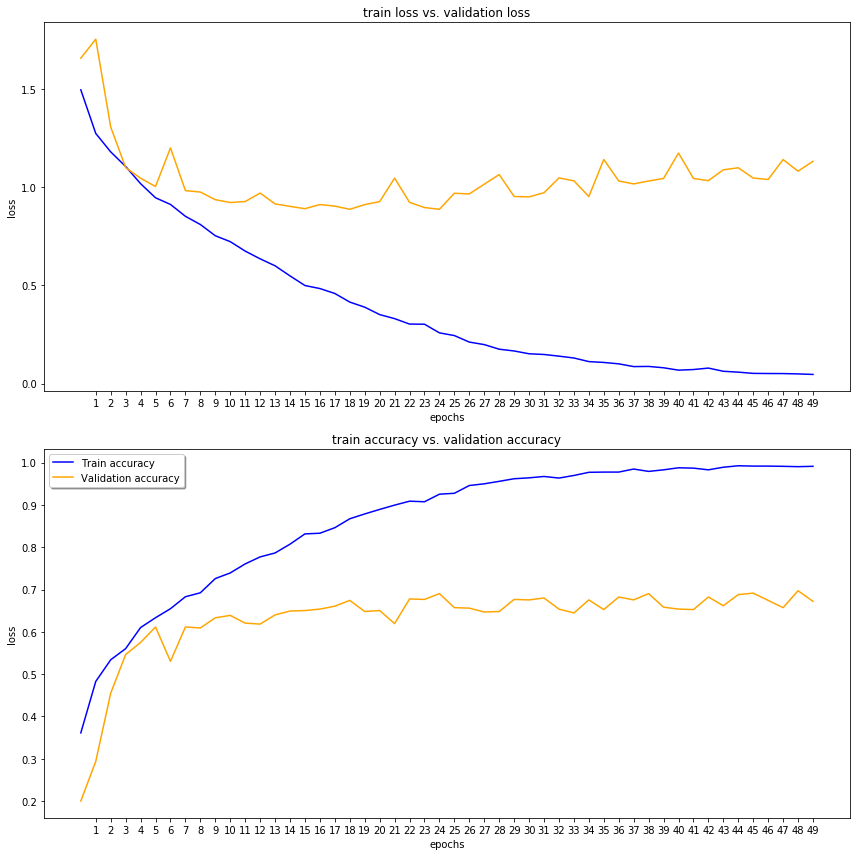

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 17

In [55]:
# lr schedule
# dense 2048,2048
# epochs 50
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 17
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
#model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
# model.add(Dense(2048))
# model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 20:
        return .0001
    elif epoch < 25:
        return .00001
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  09:13:21
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.5785 - accuracy: 0.2744
Epoch 00001: val_loss improved from inf to 1.58203, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/17-15-bsz-0.0001-lr-50-ep.01-1.58.hdf5
3750/3750 [==============================] - 85s 23ms/sample - loss: 1.5779 - accuracy: 0.2747 - val_loss: 1.5820 - val_accuracy: 0.3703
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.4729 - accuracy: 0.3588
Epoch 00002: val_loss improved from 1.58203 to 1.48266, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/17-15-bsz-0.0001-lr-50-ep.02-1.48.hdf5
3750/3750 [==============================] - 90s 24ms/sample - loss: 1.4

Epoch 23/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8485 - accuracy: 0.6814
Epoch 00023: val_loss improved from 0.92728 to 0.92200, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/17-15-bsz-0.0001-lr-50-ep.23-0.92.hdf5
3750/3750 [==============================] - 87s 23ms/sample - loss: 0.8486 - accuracy: 0.6813 - val_loss: 0.9220 - val_accuracy: 0.6469
Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8288 - accuracy: 0.6902
Epoch 00024: val_loss did not improve from 0.92200
3750/3750 [==============================] - 84s 22ms/sample - loss: 0.8289 - accuracy: 0.6904 - val_loss: 0.9220 - val_accuracy: 0.6354
Epoch 25/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8175 - accuracy: 0.6980
Epoch 00025: val_loss did not improve from 0.92200
3750/3750 [==============================] - 86s 23ms/sample - loss: 0.8170 - accuracy: 0.6981 - val_loss: 0.9351 - val_accuracy: 0.6309
Epoch 26/50
3735/3750 [===

In [56]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/17.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_97 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_98 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 12, 12, 256)     

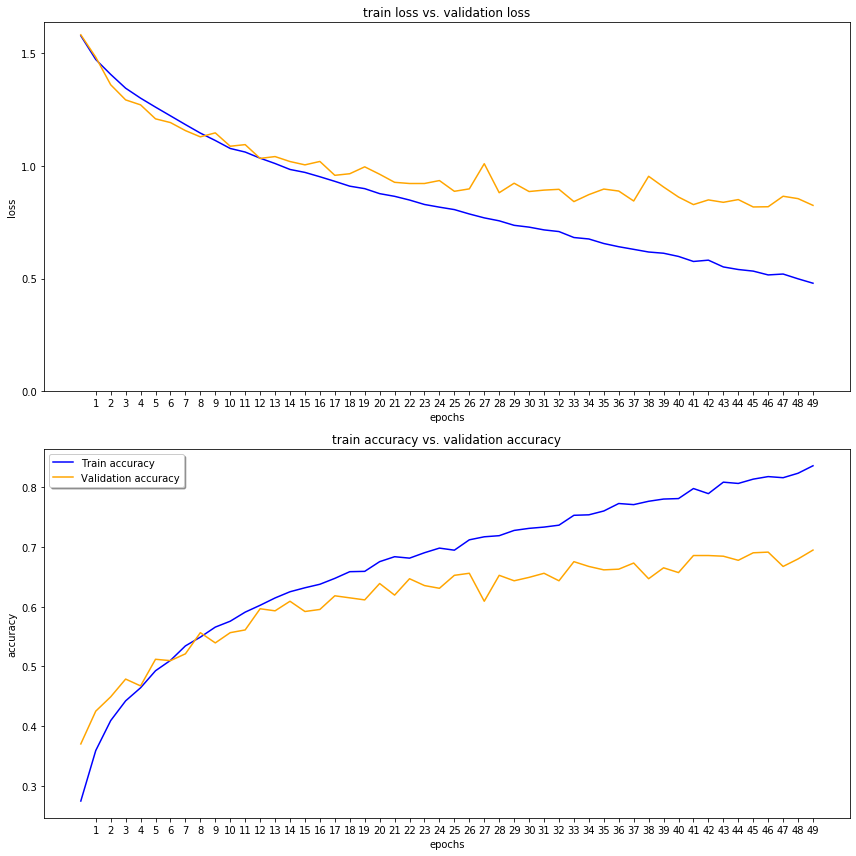

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('accuracy')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 18

In [59]:
# lr schedule
# dense 2048,2048
# epochs 50
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 18
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

#layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 5:
        return .001
    elif epoch < 25:
        return .0001
    else:
        return .00001
lr_scheduler = LearningRateScheduler(schedule)
#earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  13:22:01
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.6247 - accuracy: 0.2139
Epoch 00001: val_loss improved from inf to 1.59891, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/18-15-bsz-0.0001-lr-50-ep.01-1.60.hdf5
3750/3750 [==============================] - 101s 27ms/sample - loss: 1.6251 - accuracy: 0.2136 - val_loss: 1.5989 - val_accuracy: 0.2960
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.5628 - accuracy: 0.2867
Epoch 00002: val_loss improved from 1.59891 to 1.54644, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/18-15-bsz-0.0001-lr-50-ep.02-1.55.hdf5
3750/3750 [==============================] - 92s 25ms/sample - loss: 1.

Epoch 22/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.0423 - accuracy: 0.5912
Epoch 00022: val_loss improved from 1.05474 to 1.02074, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/18-15-bsz-0.0001-lr-50-ep.22-1.02.hdf5
3750/3750 [==============================] - 94s 25ms/sample - loss: 1.0416 - accuracy: 0.5915 - val_loss: 1.0207 - val_accuracy: 0.5749
Epoch 23/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.0365 - accuracy: 0.5885
Epoch 00023: val_loss did not improve from 1.02074
3750/3750 [==============================] - 87s 23ms/sample - loss: 1.0358 - accuracy: 0.5893 - val_loss: 1.0480 - val_accuracy: 0.5703
Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.0115 - accuracy: 0.5963
Epoch 00024: val_loss improved from 1.02074 to 1.00860, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/18-15-bsz-0.0001-lr-50-ep.24-1.01.hdf5
3750/3750 [==============================] - 87s 2

Epoch 47/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.6961
Epoch 00047: val_loss did not improve from 0.85549
3750/3750 [==============================] - 95s 25ms/sample - loss: 0.7767 - accuracy: 0.6965 - val_loss: 0.8602 - val_accuracy: 0.6663
Epoch 48/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.7467 - accuracy: 0.7149
Epoch 00048: val_loss did not improve from 0.85549
3750/3750 [==============================] - 93s 25ms/sample - loss: 0.7471 - accuracy: 0.7144 - val_loss: 0.8904 - val_accuracy: 0.6503
Epoch 49/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.7167
Epoch 00049: val_loss improved from 0.85549 to 0.82475, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/18-15-bsz-0.0001-lr-50-ep.49-0.82.hdf5
3750/3750 [==============================] - 92s 25ms/sample - loss: 0.7465 - accuracy: 0.7171 - val_loss: 0.8247 - val_accuracy: 0.6674
Epoch 50/50
3735/3750 [===

In [60]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/18.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_21 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_102 (Activation)  (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_103 (Activation)  (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 12, 12, 256)     

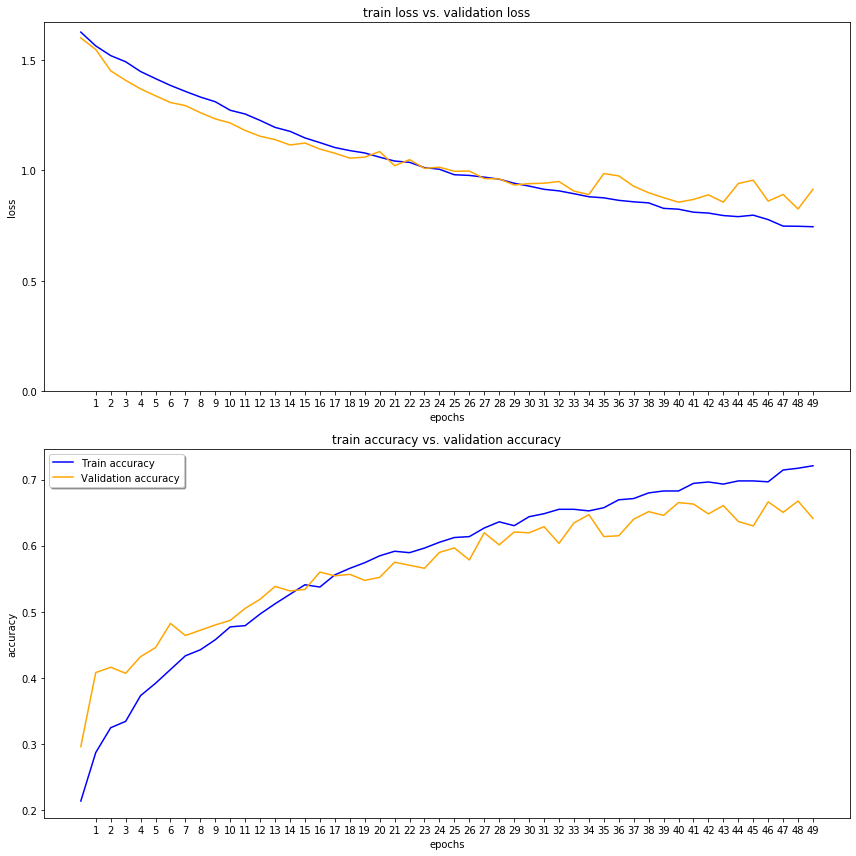

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('accuracy')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 19

In [62]:
# lr schedule 0.0001,0.00001,0.000001
# dense 2048,2048
# batch norm b1b2
# drop out d5d6
# epochs 50
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 19
learn_rate = 0.0001
epochs = 50
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

#layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 10:
        return .0001
    elif epoch < 15:
        return .00001
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)
#earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  14:43:26
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.7464 - accuracy: 0.2768
Epoch 00001: val_loss improved from inf to 1.59487, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/19-15-bsz-0.0001-lr-50-ep.01-1.59.hdf5
3750/3750 [==============================] - 106s 28ms/sample - loss: 1.7451 - accuracy: 0.2771 - val_loss: 1.5949 - val_accuracy: 0.2194
Epoch 2/50
3735/3750 [============================>.] - ETA: 0s - loss: 1.4760 - accuracy: 0.3719
Epoch 00002: val_loss improved from 1.59487 to 1.50764, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/19-15-bsz-0.0001-lr-50-ep.02-1.51.hdf5
3750/3750 [==============================] - 97s 26ms/sample - loss: 1.

Epoch 23/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8416 - accuracy: 0.6790
Epoch 00023: val_loss did not improve from 0.85731
3750/3750 [==============================] - 95s 25ms/sample - loss: 0.8410 - accuracy: 0.6795 - val_loss: 0.9049 - val_accuracy: 0.6491
Epoch 24/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8160 - accuracy: 0.6870
Epoch 00024: val_loss improved from 0.85731 to 0.83757, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/19-15-bsz-0.0001-lr-50-ep.24-0.84.hdf5
3750/3750 [==============================] - 95s 25ms/sample - loss: 0.8172 - accuracy: 0.6869 - val_loss: 0.8376 - val_accuracy: 0.6754
Epoch 25/50
3735/3750 [============================>.] - ETA: 0s - loss: 0.8044 - accuracy: 0.6851
Epoch 00025: val_loss did not improve from 0.83757
3750/3750 [==============================] - 95s 25ms/sample - loss: 0.8046 - accuracy: 0.6848 - val_loss: 0.8908 - val_accuracy: 0.6411
Epoch 26/50
3735/3750 [===

In [63]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/19.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_22 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_108 (Activation)  (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
batch_normalization_23 (Batc (None, 25, 25, 256)       1024      
_________________________________________________________________
activation_109 (Activation)  (None, 25, 25, 256)     

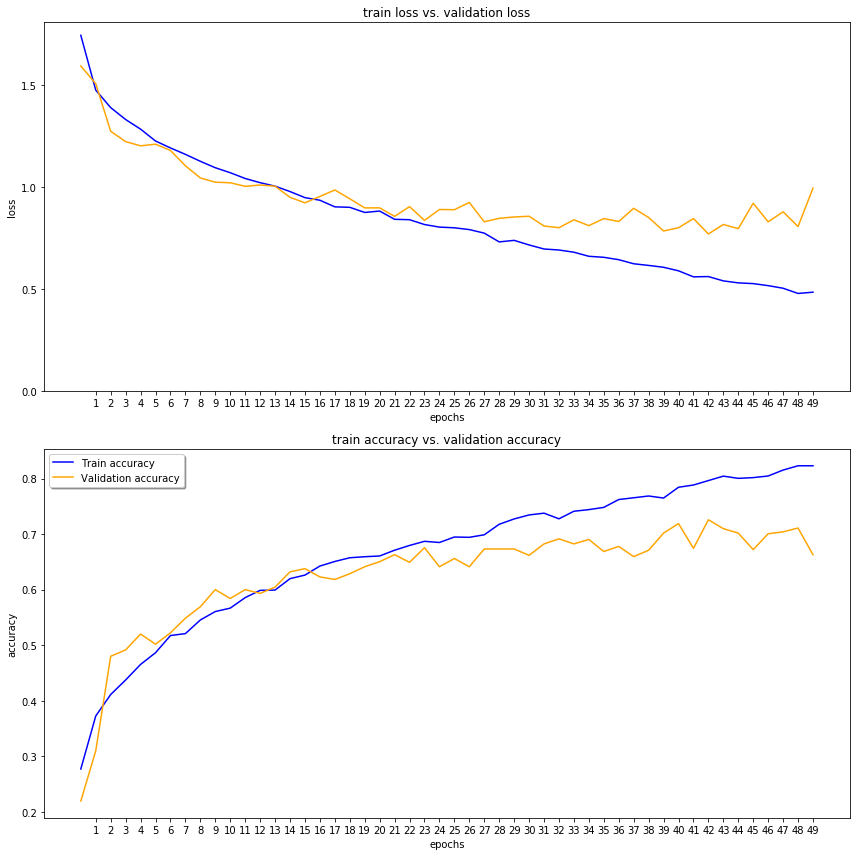

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('accuracy')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 20

In [65]:
# lr schedule 0.0001,0.00001,0.000001
# dense 2048
# batch norm b1b2
# epochs 30
# batch 15

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 20
learn_rate = 0.0001
epochs = 30
batch_size=15

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
#model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

#layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 10:
        return .0001
    elif epoch < 20:
        return .00001
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)
#earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  16:06:45
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3735/3750 [============================>.] - ETA: 0s - loss: 1.6052 - accuracy: 0.3066
Epoch 00001: val_loss improved from inf to 1.62623, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/20-15-bsz-0.0001-lr-30-ep.01-1.63.hdf5
3750/3750 [==============================] - 100s 27ms/sample - loss: 1.6047 - accuracy: 0.3067 - val_loss: 1.6262 - val_accuracy: 0.2034
Epoch 2/30
3735/3750 [============================>.] - ETA: 0s - loss: 1.3544 - accuracy: 0.4273
Epoch 00002: val_loss improved from 1.62623 to 1.59211, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/20-15-bsz-0.0001-lr-30-ep.02-1.59.hdf5
3750/3750 [==============================] - 95s 25ms/sample - loss: 1.

KeyError: 'val_loss'

In [ ]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/20.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('accuracy')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 21

In [66]:
# same as 18 but batch size 32 30 epoch

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 21
learn_rate = 0.0001
epochs = 30
batch_size= 32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

#layer 7: FC7 + Relu
model.add(Dense(2048))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 5:
        return .001
    elif epoch < 25:
        return .0001
    else:
        return .00001
lr_scheduler = LearningRateScheduler(schedule)
#earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  16:35:58
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.6383 - accuracy: 0.2222
Epoch 00001: val_loss improved from inf to 1.60638, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/21-32-bsz-0.0001-lr-30-ep.01-1.61.hdf5
3750/3750 [==============================] - 88s 24ms/sample - loss: 1.6383 - accuracy: 0.2221 - val_loss: 1.6064 - val_accuracy: 0.2560
Epoch 2/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.5897 - accuracy: 0.2636
Epoch 00002: val_loss improved from 1.60638 to 1.59911, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/21-32-bsz-0.0001-lr-30-ep.02-1.60.hdf5
3750/3750 [==============================] - 82s 22ms/sample - loss: 1.5

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_26 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_120 (Activation)  (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_121 (Activation)  (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 12, 12, 256)     

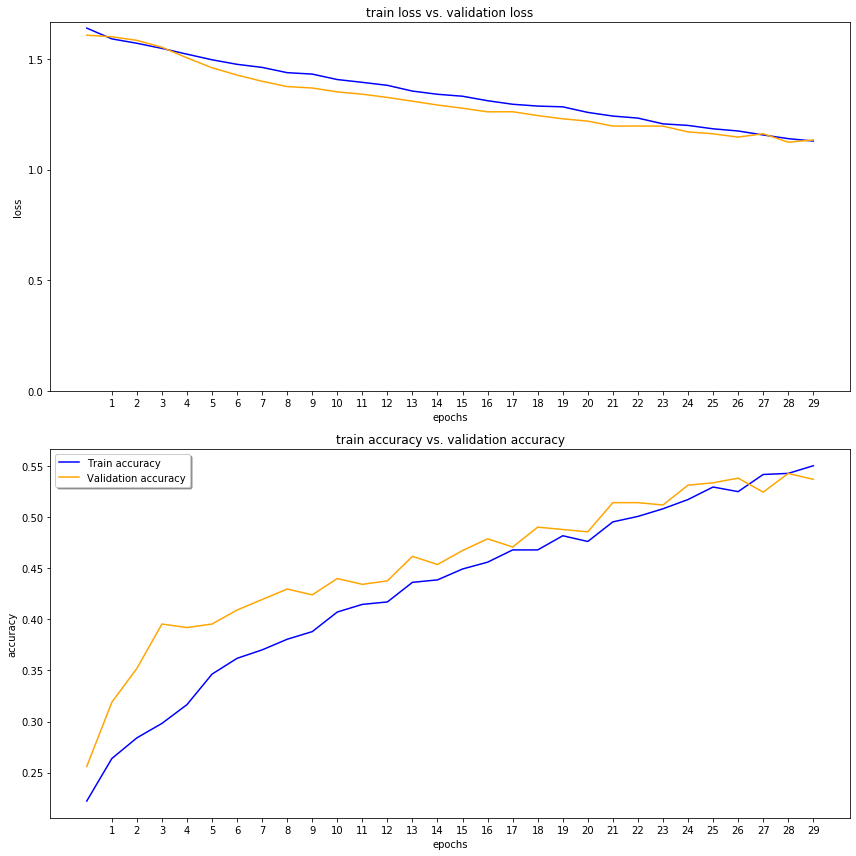

In [71]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/20.h5')
model.summary()



# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('accuracy')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()